<a href="https://colab.research.google.com/github/MaricelaMH/Simulacion-1/blob/main/Otras_aplicaciones_ej.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

E - J - E - R - C - I - C - I - O   --- 5.10

La demanda diaria y el tiempo de entrega de un cierto producto, siguen las siguientes distribuciones de probabilidad:

![texto alternativo](https://drive.google.com/uc?id=1N6Od4AThez6NpVqWDsv1cl5RuaXcxp6l)

La información con respecto a los costos relevantes es la siguiente:
$$\text{Costo de ordenar } = \$ 50 / orden $$
$$ \text{Costo de inventario = } \$26 /unidad/año $$
$$ \text{Costo de faltante = } \$25 /unidad $$

Si el inventario inicial es de 15 unidades, ¿Determine la cantidad óptima a ordenar $(q)$ y el nivel optimo de reorden $(R)$? (Asuma que se trabajan 260 dias en el año.)



In [17]:
# Importamos librerias necesarias
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from tabulate import tabulate

Inicializaremos una función que simula la demanda diaria de un producto. Usa una distribución de probabilidad acumulativa para determinar la demanda diaria basada en un número aleatorio generado.

In [36]:
def demanda():  # Función para calcular la demanda diaria
    demanda_diaria = [0, 1, 2, 3, 4, 5, 6, 7, 8] # Demanda diaria
    prob_demanda = [0.04, 0.06, 0.10, 0.20, 0.30, 0.18, 0.08, 0.03, 0.01]  # Probabilidad
    u = rnd.random() # Generamos un número aleatorio
    prob_acom = np.cumsum(prob_demanda) # Probabilidad acumulada
    for i, prob in enumerate(prob_acom):
        if u <= prob:  # Verificamos si el numero aleatorio esta en el rango de probabilidad
            return demanda_diaria[i], u

Ahira simularemos el tiempo de entrega del producto. De manera similar a la función de demanda, utiliza una distribución de probabilidad acumulativa para determinar el tiempo de entrega basado en un número aleatorio generado.

In [37]:
def tiemp_entrega():  # Función para calcular el tiempo de entrega
    tiempo = [1, 2, 3, 4] # Tienpo de entrega
    prob_tiempo = [0.25, 0.50, 0.20, 0.05] # Probabilidad
    v = rnd.random() # Generamos un numero aleatorio
    prob_acom = np.cumsum(prob_tiempo) # Probabilidad acumulada
    for i, prob in enumerate(prob_acom):
        if v <= prob: # Verificamos si el numero aleatorio esta en el rango
            return tiempo[i]

Esta es la función principal que simula el inventario del sistema a lo largo de un año de trabajo (260 días). Utilizaremos las funciones de demanda y tiempo de entrega para calcular el inventario diario, el inventario faltante y el costo total.
También calcula si se necesita hacer un nuevo pedido (cuando el inventario cae por debajo del punto de reorden R) y, si es así, generaremos un tiempo de entrega.

In [38]:
def inventario(q, R):  # Función principal de inventario
    inv_inicial = 15  # Inventario inicial es 15 unidades
    inventario_i = [inv_inicial] # Lista para almacenar los inventarios diarios
    inv_falt = 0
    carga_pend = False
    tie_entrega = 0
    cont = -1
    faltante = 0
    lista = []
    cont_ent = 0

    for dia in range(260):  # Consideramos un ciclo de 260 días
        dem, _ = demanda()  # Llamamos a la función de demanda
        inv_final = inv_inicial - dem  # Calculamos inventario final

        if inv_final <= R and not carga_pend:  # Verificamos si se necesita hacer un nuevo pedido
            tie_entrega = tiemp_entrega() # Llamamos a la funcion tiempo de entrega
            carga_pend = True  # Marcamos que es necesario hacer un nuevo pedido
            cont_ent += 1

        if carga_pend:
            cont += 1

        if inv_final < 0: # Verificamos si el inventario cae por de bajo del punto de reorden
            faltante = abs(inv_final) # Calculamos faltante
            lista.append([dia+1, inv_inicial, dem, "-", faltante, tie_entrega])
            inv_falt += faltante
        else:
            lista.append([dia+1, inv_inicial, dem, inv_final, faltante, tie_entrega])

        inv_inicial = inv_final # Actualizamos el inventario inicial

        if cont == tie_entrega: # Verificamos si se cumple el tiempo de entrega
            cont = -1
            inv_inicial += q
            carga_pend = False
            tie_entrega = 0

        faltante = 0
        inventario_i.append(inv_inicial) # Almacenamos el inventario diario

    suma_inv_prom = sum(inv_inicial for dia, inv_inicial, dem, inv_final, faltante, tie_entrega in lista if inv_final != "-")
    costo_total = cont_ent * 50 + suma_inv_prom * 26/260 + inv_falt * 25 # Calculamos el costo total

    return costo_total, lista, inventario_i, cont_ent, suma_inv_prom, inv_falt


La optimización de $q$ (cantidad a ordenar) y $R$ (nivel de reorden) se realiza utilizando el método de Hooke-Jeeves. Este método es un algoritmo de búsqueda directa utilizado para minimizar una función objetivo en un espacio de búsqueda.
Asi definimos la función objetivo "funcion_objetivo" que toma un par de valores $[q,R]$, ejecuta la simulación de inventario con estos valores y devuelve el costo total del sistema de inventario.

In [39]:
# Función objetivo para Hooke-Jeeves
def funcion_objetivo(parametros):
    q, R = map(int, parametros) # Convertimos a enteros
    costo_total, _, _, _, _, _ = inventario(q, R) # Lamamos a nuestra función inventario
    return costo_total

Si encuentra una mejor solución, se actualiza el punto base. Si no encuentra una mejor solución, reduce el tamaño del paso delta y repite el proceso hasta que el tamaño del paso sea menor que epsilon.

In [40]:
# Método de Hooke-Jeeves
def hooke_jeeves(func, x0, delta, gamma, epsilon):  # Definimos nuestra función de Hooke_Jeeves
    x = np.array(x0, dtype=float)     # Base inicial: se inicializa con el punto de partida x0,
                                      # que contiene los valores iniciales de q y R
    delta = np.array(delta, dtype=float) # Se inicializa el paso exploratorio inicial
    while np.any(delta > epsilon):       # Mientras haya pasos mayores que el criterio de parada
        mejorada = False
        for i in range(len(x)):
            for direc in [-1, 1]:
                x_nev = x.copy()
                x_nev[i] += direc * delta[i]
                if func(x_nev) < func(x):  #  Si se encuentra una mejor solución
                    x = x_nev       #  Actualizamos el punto base
                    mejorada = True
                    break
            if mejorada:
                break
        if not mejorada: # Si no se encuentra una mejor solución
            delta *= gamma # Reducimos el tamaño del paso
    return x

In [45]:
# Parámetros iniciales para Hooke-Jeeves
x0 = [50, 20]  # Valores iniciales de q y R
delta = [10.0, 10.0]  # Longitud de paso inicial
gamma = 0.5  # Factor de reducción
epsilon = 0.01  # Criterio de parada
# Ejecutar Hooke-Jeeves
q_opt, R_opt = hooke_jeeves(funcion_objetivo, x0, delta, gamma, epsilon)

Después de encontrar los valores óptimos $q$ y $R$, se ejecuta nuevamente la simulación de inventario para calcular los costos y generar los resultados finales.
Comparamos los costos finales

In [46]:
# Comparar valores iniciales y óptimos
costo_inicial, lista_inicial, inventario_i_inicial, cont_ent_inicial, suma_inv_prom_inicial, inv_falt_inicial = inventario(50,20)
costo_optimo, lista_optima, inventario_i_optima, cont_ent_optima, suma_inv_prom_optima, inv_falt_optima = inventario(q_opt, R_opt)

# Imprimir comparación
print(f'Valores iniciales: q = {x0[0]}, R = {x0[1]}')
print(f'Costo total inicial: {costo_inicial}')
print(f'Valores óptimos: q = {q_opt}, R = {R_opt}')
print(f'Costo total óptimo: {costo_optimo}')


Valores iniciales: q = 50, R = 20
Costo total inicial: 2009.2
Valores óptimos: q = 59.55078125, R = 14.1015625
Costo total óptimo: 1976.022265625


In [47]:
# Imprimir tablas
headers = ['Día', 'Inventario inicial', 'Demanda', 'Inventario final', 'Faltante', 'Entrega']

In [48]:
print("Resultados con valores iniciales:")
print(tabulate(lista_inicial, headers=headers, tablefmt="fancy_grid", showindex=False))


Resultados con valores iniciales:
╒═══════╤══════════════════════╤═══════════╤════════════════════╤════════════╤═══════════╕
│   Día │   Inventario inicial │   Demanda │   Inventario final │   Faltante │   Entrega │
╞═══════╪══════════════════════╪═══════════╪════════════════════╪════════════╪═══════════╡
│     1 │                   15 │         3 │                 12 │          0 │         1 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     2 │                   12 │         4 │                  8 │          0 │         1 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     3 │                   58 │         5 │                 53 │          0 │         0 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     4 │                   53 │         6 │                 47 │          0 │         0 │
├───────┼──────────────────────┼───────────┼────────────

In [49]:
print("Resultados con valores óptimos:")
print(tabulate(lista_optima, headers=headers, tablefmt="fancy_grid", showindex=False))

Resultados con valores óptimos:
╒═══════╤══════════════════════╤═══════════╤════════════════════╤════════════╤═══════════╕
│   Día │   Inventario inicial │   Demanda │ Inventario final   │   Faltante │   Entrega │
╞═══════╪══════════════════════╪═══════════╪════════════════════╪════════════╪═══════════╡
│     1 │             15       │         4 │ 11                 │   0        │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     2 │             11       │         3 │ 8                  │   0        │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     3 │              8       │         3 │ 5                  │   0        │         2 │
├───────┼──────────────────────┼───────────┼────────────────────┼────────────┼───────────┤
│     4 │             64.5508  │         4 │ 60.55078125        │   0        │         0 │
├───────┼──────────────────────┼───────────┼──────────────

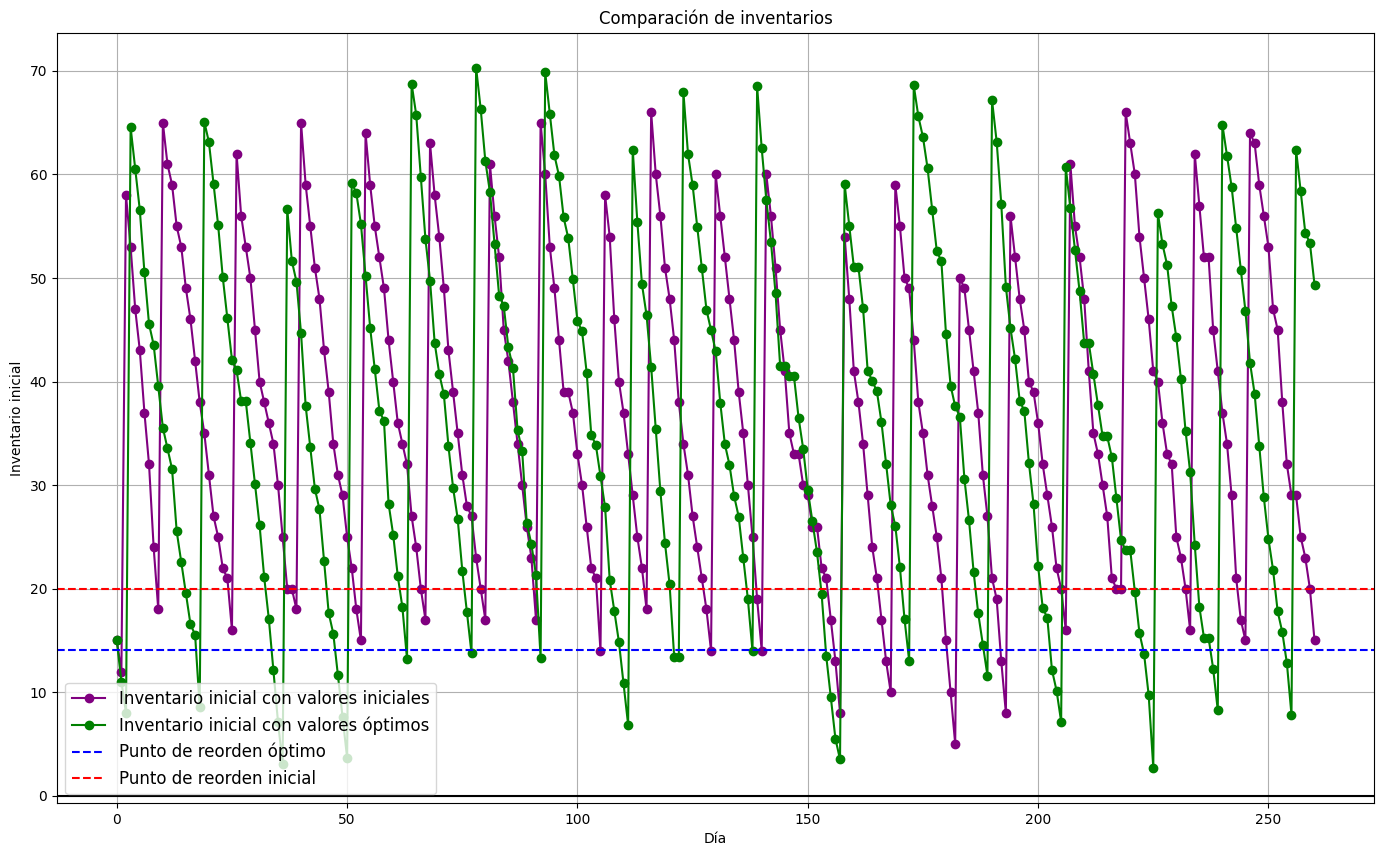

In [55]:
# Graficar comparación de inventarios
plt.figure(figsize=(17, 10))  # Aumentar el tamaño de la figura
plt.plot(inventario_i_inicial, color="purple", marker='o', label="Inventario inicial con valores iniciales")
plt.plot(inventario_i_optima, color="green", marker='o', label="Inventario inicial con valores óptimos")
plt.title('Comparación de inventarios')
plt.xlabel('Día')
plt.ylabel('Inventario inicial')
plt.axhline(R_opt, color="blue", linestyle='--', label='Punto de reorden óptimo')
plt.axhline(x0[1], color="red", linestyle='--', label='Punto de reorden inicial')
plt.axhline(0, color='black')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [56]:
# Imprimir costos
costo_inicial_detalle = [cont_ent_inicial * 50, suma_inv_prom_inicial * 26/260, inv_falt_inicial * 25, costo_inicial]
costo_optimo_detalle = [cont_ent_optima * 50, suma_inv_prom_optima * 26/260, inv_falt_optima * 25, costo_optimo]

In [57]:
print("Costos con valores iniciales:")
print(tabulate([costo_inicial_detalle], headers=['Costo de ordenar', 'Costo de llevar el inventario', 'Costo de faltante', 'Costo total'], tablefmt="fancy_grid", showindex=False))


Costos con valores iniciales:
╒════════════════════╤═════════════════════════════════╤═════════════════════╤═══════════════╕
│   Costo de ordenar │   Costo de llevar el inventario │   Costo de faltante │   Costo total │
╞════════════════════╪═════════════════════════════════╪═════════════════════╪═══════════════╡
│               1050 │                           959.2 │                   0 │        2009.2 │
╘════════════════════╧═════════════════════════════════╧═════════════════════╧═══════════════╛


In [58]:
print("Costos con valores óptimos:")
print(tabulate([costo_optimo_detalle], headers=['Costo de ordenar', 'Costo de llevar el inventario', 'Costo de faltante', 'Costo total optimo'], tablefmt="fancy_grid", showindex=False))

Costos con valores óptimos:
╒════════════════════╤═════════════════════════════════╤═════════════════════╤══════════════════════╕
│   Costo de ordenar │   Costo de llevar el inventario │   Costo de faltante │   Costo total optimo │
╞════════════════════╪═════════════════════════════════╪═════════════════════╪══════════════════════╡
│                850 │                         950.339 │             175.684 │              1976.02 │
╘════════════════════╧═════════════════════════════════╧═════════════════════╧══════════════════════╛


Finalmente los valores optimos para este caso son:
$$q = 59.55078125 \approx 60 $$
$$ R = 14.1015625 \approx 14 $$

con un costo optimo de
$$ \$ 1976.02 $$